In [2]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, SegResNet, UNet
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


In [3]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [4]:
data_dir = '/home/ikboljon.sobirov/data/fs1_research/Ikboljon.Sobirov/imagecas/imagecas/resampled_space/'
json_file = '/home/ikboljon.sobirov/data/nas/ikboljon.sobirov/image_cas/chuqur_organish_asoslari/module_6/train_data.json'
fold = 1
roi = (96, 96, 96)
batch_size = 4


In [5]:
train_files, validation_files = datafold_read(datalist=json_file, basedir=data_dir, fold=fold)
# 200, 100

In [6]:
# z_norm = (img - mean)/std
# min_max = (img - min)/(max - min)

In [7]:
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image_path", "mask_path"], ensure_channel_first=True),
        transforms.SpatialPadd(keys=["image_path", "mask_path"], spatial_size=roi),
        transforms.RandCropByPosNegLabeld(keys=["image_path", "mask_path"], 
                                        label_key="mask_path",
                                        spatial_size=roi,
                                        num_samples=4,
                                        image_key="image_path",),
        # transforms.CropForegroundd(
        #     keys=["image", "label"],
        #     source_key="image",
        #     k_divisible=[roi[0], roi[1], roi[2]],
        # ),
        # transforms.RandSpatialCropd(
        #     keys=["image", "label"],
        #     roi_size=[roi[0], roi[1], roi[2]],
        #     random_size=False,
        # ),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        # transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        # transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        # transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image_path", "mask_path"], ensure_channel_first=True),
        transforms.SpatialPadd(keys=["image_path", "mask_path"], spatial_size=roi),
    ]
)

train_ds = data.Dataset(data=train_files, transform=train_transform)

train_loader = data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

val_ds = data.Dataset(data=validation_files, transform=val_transform)
val_loader = data.DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)



In [8]:
a = next(iter(train_loader))

In [19]:
a['mask_path'].shape

torch.Size([4, 1, 96, 96, 96])

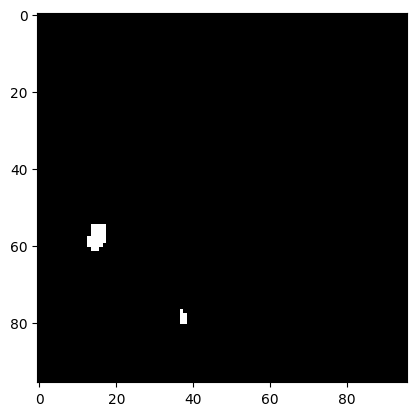

In [15]:
plt.imshow(a['mask_path'].cpu().detach()[0, 0, :, :, 25], cmap='gray')

In [12]:
model = SegResNet(
    in_channels=1,
    out_channels=1,
)

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

loss_function = DiceLoss(to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dice_metric = DiceMetric(include_background=False, reduction=MetricReduction.MEAN)

max_epochs = 100
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
# post_label = AsDiscrete(to_onehot=True, n_classes=2)




In [ ]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image_path"].to(device), batch_data["mask_path"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image_path"].to(device), val_data["mask_path"].to(device)
                val_outputs = model(val_inputs)
                value = dice_metric(y_pred=val_outputs, y=val_labels)
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f} "
                f"best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(range(max_epochs), epoch_loss_values, "r", label="train loss")
ax1.set_xlabel("epoch", color="k")
ax1.set_ylabel("Loss", color="r")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(range(max_epochs), metric_values, "b", label="val mean dice")
ax2.set_ylabel("Dice", color="b")
ax2.legend(loc="upper right")

plt.show()
